### Generation

In [1]:
! pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.7 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import torch

def get_integrator_basis_fn(sde):
    def _worker(t_start, t_end, num_item):
        dt = (t_end - t_start) / num_item

        t_inter = jnp.linspace(t_start, t_end, num_item, endpoint=False)
        psi_coef = sde.psi(t_inter, t_end)
        integrand = sde.eps_integrand(t_inter)

        return psi_coef * integrand, t_inter, dt
    return _worker


def single_poly_coef(t_val, ts_poly, coef_idx=0):
    num = t_val - ts_poly
    denum = ts_poly[coef_idx] - ts_poly
    num = num.at[coef_idx].set(1.0)
    denum = denum.at[coef_idx].set(1.0)
    return jnp.prod(num) / jnp.prod(denum)

vec_poly_coef = jax.vmap(single_poly_coef, (0, None, None), 0)


def get_one_coef_per_step_fn(sde):
    _eps_coef_worker_fn = get_integrator_basis_fn(sde)
    def _worker(t_start, t_end, ts_poly, coef_idx=0,num_item=10000):
        integrand, t_inter, dt = _eps_coef_worker_fn(t_start, t_end, num_item)
        poly_coef = vec_poly_coef(t_inter, ts_poly, coef_idx)
        return jnp.sum(integrand * poly_coef) * dt
    return _worker

def get_coef_per_step_fn(sde, highest_order, order):
    eps_coef_fn = get_one_coef_per_step_fn(sde)
    def _worker(t_start, t_end, ts_poly, num_item=10000):
        rtn = jnp.zeros((highest_order+1, ), dtype=float)
        ts_poly = ts_poly[:order+1]
        coef = jax.vmap(eps_coef_fn, (None, None, None, 0, None))(t_start, t_end, ts_poly, jnp.flip(jnp.arange(order+1)), num_item)
        rtn = rtn.at[:order+1].set(coef)
        return rtn
    return _worker

def get_ab_eps_coef_order0(sde, highest_order, timesteps):
    _worker = get_coef_per_step_fn(sde, highest_order, 0)
    col_idx = jnp.arange(len(timesteps)-1)[:,None]
    idx = col_idx + jnp.arange(1)[None, :]
    vec_ts_poly = timesteps[idx]
    return jax.vmap(
        _worker,
        (0, 0, 0), 0
    )(timesteps[:-1], timesteps[1:], vec_ts_poly)

def get_ab_eps_coef(sde, highest_order, timesteps, order):
    if order == 0:
        return get_ab_eps_coef_order0(sde, highest_order, timesteps)

    prev_coef = get_ab_eps_coef(sde, highest_order, timesteps[:order+1], order=order-1)

    cur_coef_worker = get_coef_per_step_fn(sde, highest_order, order)

    col_idx = jnp.arange(len(timesteps)-order-1)[:,None]
    idx = col_idx + jnp.arange(order+1)[None, :]
    vec_ts_poly = timesteps[idx]


    cur_coef = jax.vmap(
        cur_coef_worker,
        (0, 0, 0), 0
    )(timesteps[order:-1], timesteps[order+1:], vec_ts_poly) #[3, 4, (0,1,2,3)]

    return jnp.concatenate(
        [
            prev_coef,
            cur_coef
        ],
        axis=0
    )

def ab_step(x, ei_coef, new_eps, eps_pred):
    x_coef, eps_coef = ei_coef[0], ei_coef[1:]
    full_eps_pred = [new_eps, *eps_pred]
    rtn = x_coef * x
    for cur_coef, cur_eps in zip(eps_coef, full_eps_pred):
        rtn += cur_coef * cur_eps
    return rtn, full_eps_pred[:-1]


def get_rev_ts(exp_sde, num_step, ts_order):
    t0, t1 = 0, exp_sde.T
    t0 = t0 + 1e-1
    rev_ts = jnp.power(
        jnp.linspace(
            jnp.power(t1, 1.0 / ts_order),
            jnp.power(t0, 1.0 / ts_order),
            num_step + 1
        ),
        ts_order
    )
    return rev_ts

def jax2th(array, th_array=None):
    if th_array is None:
        return torch.from_numpy(
            np.asarray(array).copy()
        )
    else:
        return torch.from_numpy(
            np.asarray(array).copy()
        ).to(th_array.device)

def fori_loop(lower, upper, body_fun, init_val):
    val = init_val
    for i in range(lower, upper):
        val = body_fun(i, val)
    return val

def sample(sde, eps_fn, ts_order, num_step, ab_order, noise):
    rev_ts = get_rev_ts(sde, num_step, ts_order)

    x_coef = sde.psi(rev_ts[:-1], rev_ts[1:])
    eps_coef = get_ab_eps_coef(sde, ab_order, rev_ts, ab_order)
    ab_coef = jnp.concatenate([x_coef[:, None], eps_coef], axis=1)
    rev_ts, ab_coef = jax2th(rev_ts), jax2th(ab_coef)
    rev_ts, ab_coef = rev_ts.to(noise.device), ab_coef.to(noise.device)

    def ab_body_fn(i, val):
        x, eps_pred = val
        s_t= rev_ts[i]

        new_eps = eps_fn(x, s_t)
        new_x, new_eps_pred = ab_step(x, ab_coef[i], new_eps, eps_pred)
        return new_x, new_eps_pred


    eps_pred = [noise,] * ab_order
    img, _ = fori_loop(0, num_step, ab_body_fn, (noise, eps_pred))
    return img

In [3]:
import torch
import jax
import jax.numpy as jnp
from torch import nn

criterion = nn.MSELoss()

class VPSDE():
    def __init__(self, beta_min=0.1, beta_max=20):
        """Construct a Variance Preserving SDE.

        Args:
        beta_min: value of beta(0)
        beta_max: value of beta(1)
        N: number of discretization steps
        """
        super().__init__()
        self.beta_0 = beta_min
        self.beta_1 = beta_max
        self.t2alpha_fn = lambda t: jnp.exp(2 * (-0.25 * t ** 2 * (self.beta_1 - self.beta_0) - 0.5 * t * self.beta_0))
        log_alpha_fn = lambda t: jnp.log(self.t2alpha_fn(t))
        grad_log_alpha_fn = jax.grad(log_alpha_fn)
        self.d_log_alpha_dtau_fn = jax.vmap(grad_log_alpha_fn)

    @property
    def T(self):
        return 1

    def marginal_prob(self, x, t):
        log_mean_coeff = -0.25 * t ** 2 * (self.beta_1 - self.beta_0) - 0.5 * t * self.beta_0
        mean = torch.exp(log_mean_coeff[:, None, None, None]) * x
        std = torch.sqrt(1. - torch.exp(2. * log_mean_coeff))
        return mean, std

    def psi(self, t_start, t_end):
        return jnp.sqrt(self.t2alpha_fn(t_end) / self.t2alpha_fn(t_start))

    def eps_integrand(self, vec_t):
        d_log_alpha_dtau = self.d_log_alpha_dtau_fn(vec_t)
        integrand = -0.5 * d_log_alpha_dtau / jnp.sqrt(1 - self.t2alpha_fn(vec_t))
        return integrand

def loss_fn(sde, model, x, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (sde.T - eps) + eps
    z = torch.randn_like(x)
    mean, std = sde.marginal_prob(x, random_t)
    perturbed_x = mean + z * std[:, None, None, None]
    pred_noise = model(perturbed_x, random_t)["sample"]
    loss = criterion(pred_noise, z)
    return loss



In [4]:
from diffusers import UNet2DModel
import typing as tp

def get_model(repo_id: tp.Optional[str] = None, **kwargs) -> UNet2DModel:
    model = UNet2DModel.from_pretrained(repo_id, use_safetensors=True) if repo_id else UNet2DModel(
            in_channels=3,
            out_channels=3,
            block_out_channels=(64, 64, 128),
            down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
            ),
            **kwargs
        )

    return model

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [141]:
import torch

vpsde = VPSDE()
ts_order = 2.0
num_step=1000
ab_order=3
B, C, H, W = 1000, 3, 28, 28
TIME_EMB_TYPE = "fourier"
DEVICE = "cuda"

model = get_model(sample_size = H, time_embedding_type = TIME_EMB_TYPE)
model.load_state_dict(torch.load("drive/MyDrive/Bayes/ckpt_score_2.pth",map_location=torch.device(DEVICE))["model_state_dict"])
model.to(DEVICE)
model.eval()

def eps_fn(x_t, scalar_t):
    vec_t = (torch.ones(x_t.shape[0])).float().to(x_t) * scalar_t
    with torch.no_grad():
        score = model(x_t, vec_t)["sample"]
    std = vpsde.marginal_prob(torch.zeros_like(score), vec_t)[1]
    eps = - score/ std[:, None, None, None]
    return eps

# Example how to sample image

images = sample(
    sde = vpsde,
    eps_fn = eps_fn,
    ts_order=ts_order,
    num_step=num_step,
    ab_order=ab_order,
    noise=torch.randn(B, C, H, W).to(DEVICE)
)



In [142]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def normalize(imgs):
    return (torch.clip(imgs, -1, 1) + 1)/2

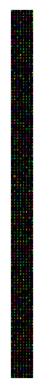

In [143]:
from torchvision.utils import make_grid

show(make_grid(normalize(images)))

In [144]:
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from pathlib import Path

def save_imgs(images, path):
    for ind, image in tqdm(enumerate(images)):
        save_image(image, path / (str(ind) + ".png"))

In [145]:
path_to_dir = Path(f"./drive/MyDrive/Bayes/EI({int(ab_order)})_{int(num_step)}")
path_to_dir.mkdir()
save_imgs(normalize(images), path_to_dir)

0it [00:00, ?it/s]

In [146]:
images = sample(
    sde = vpsde,
    eps_fn = eps_fn,
    ts_order=ts_order,
    num_step=num_step,
    ab_order=0,
    noise=torch.randn(B, C, H, W).to(DEVICE)
)

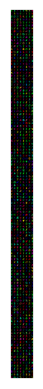

In [147]:
show(make_grid(normalize(images)))

In [148]:
path_to_dir = Path(f"./drive/MyDrive/Bayes/DDIM_{int(num_step)}")
path_to_dir.mkdir()
save_imgs(normalize(images), path_to_dir)

0it [00:00, ?it/s]

### FID

In [108]:
! pip install pytorch-fid

In [111]:
! pip install scipy==1.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [150]:
! python -m pytorch_fid ./drive/MyDrive/Bayes/colored_mnist_train ./drive/MyDrive/Bayes/EI\(3\)_1000 --device cuda

100% 22/22 [00:04<00:00,  4.75it/s]
100% 20/20 [00:04<00:00,  4.41it/s]
FID:  19.77535768809949


In [138]:
ei_dict ={
    1000:19.77535768809949,
    100:29.486502306522198,
    80:33.40547486083264,
    50:38.96245444381802,
    30:38.852168933082595,
    20:80.84373240807318,
    10:118.97699411526611,
    7:68.20150260696002,
    5:114.92699020875753,
    4:166.17547801487413, # 2 -- 176.6697891159079
    3:204.83888049586358, # 2 -- 228.98555939597503
    2:184.17271380626477 # 1 -- 188.66317976549425
}

ddim_dict ={
    1000:17.96478044731134,
    100:19.549185199863388,
    80:18.982991754251145,
    50:17.577593625479636,
    30:18.07812605159279,
    20:18.87175873086386,
    10:47.32729999897043,
    7:95.22048173047628,
    5:149.39568290730233,
    4:171.99395783283063,
    3:153.30869201391963,
    2:166.7198723590123
}

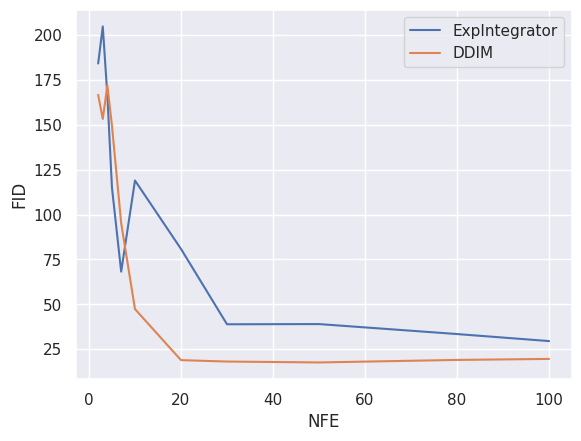

In [140]:
import matplotlib.pylab as plt
import seaborn as sns

sns.set()

plt.plot(list(ei_dict.keys()), list(ei_dict.values()), label = "ExpIntegrator")
plt.plot(list(ddim_dict.keys()), list(ddim_dict.values()), label = "DDIM")

plt.legend()
plt.xlabel("NFE")
plt.ylabel("FID");